In [1]:
import FinanceDataReader as fdr
import datetime
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

df = fdr.DataReader('GOOG' , start='2012-10-31' ,end='2022-10-31')
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-26,96.760002,98.540001,94.570000,94.820000,94.820000,71504300
2022-10-27,94.309998,95.169998,91.900002,92.599998,92.599998,54036500
2022-10-28,92.529999,96.860001,92.322998,96.580002,96.580002,35696900


### 시계열 데이터, 이동평균, 이동표준편차 시각화

In [2]:
def plot_rolling(data , interval):
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()

    plt.figure(figsize=(10, 6))
    plt.xlabel('Date')
    plt.plot(data , color='blue', label='Original')
    plt.plot(rolmean , color='red', label=f'Rolling mean {interval}')
    plt.plot(rolstd , color='black', label=f'Rolling std {interval}')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Std')
    plt.show()

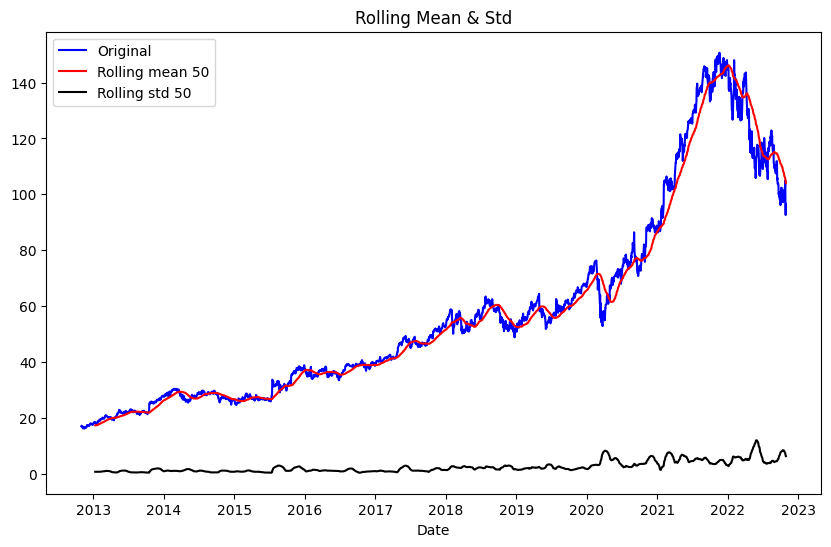

In [3]:
plot_rolling(df['Adj Close'], 50)

In [ ]:
df.plot(figsize=[12, 8])
plt.title('Google', fontsize=16)
plt.show()

### 정상성 데이터 확인 - ADF 테스트

In [4]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Adj Close'])

In [5]:
result

(-0.7728513690427873,
 0.8269670022786417,
 24,
 2492,
 {'1%': -3.432976825339513,
  '5%': -2.862700515844509,
  '10%': -2.5673877878037974},
 8123.380743513813)

### 차분

In [6]:
from statsmodels.tsa.stattools import adfuller

## ADF
def ADF(data):

    result = adfuller(data, autolag="AIC")

    print("---- Adfuller ----")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %1.10f' % result[1])
    print('Lag: %d' % result[2])
    print('observation: %d' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [7]:
df_diff1 = df['Adj Close'].diff().dropna()

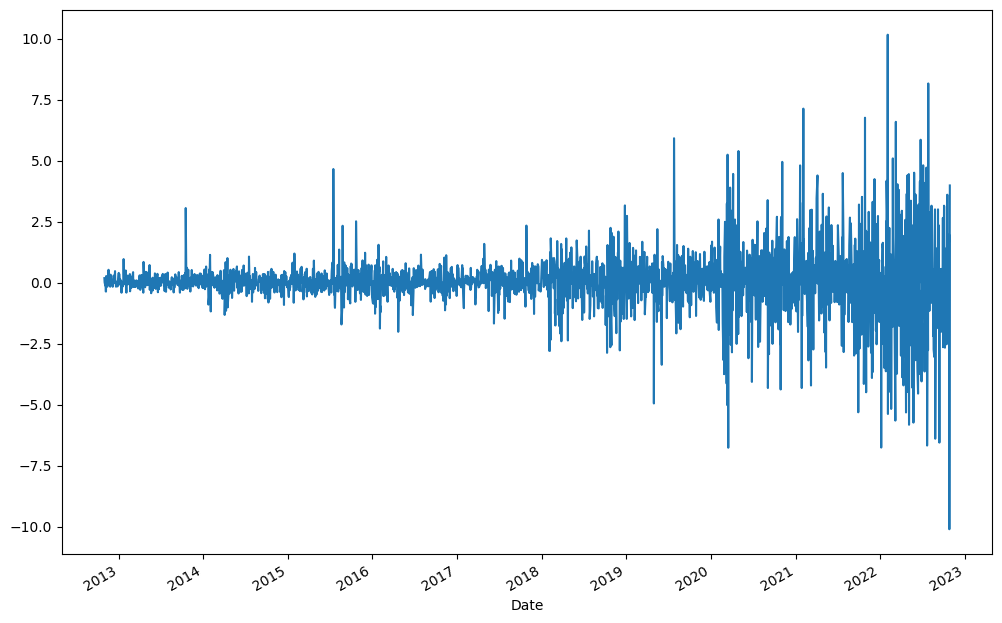

In [9]:
df_diff1.plot(figsize=(12,8))
plt.show()

In [10]:
ADF(df_diff1)

---- Adfuller ----
ADF Statistic: -10.592716
p-value: 0.0000000000
Lag: 23
observation: 2492
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


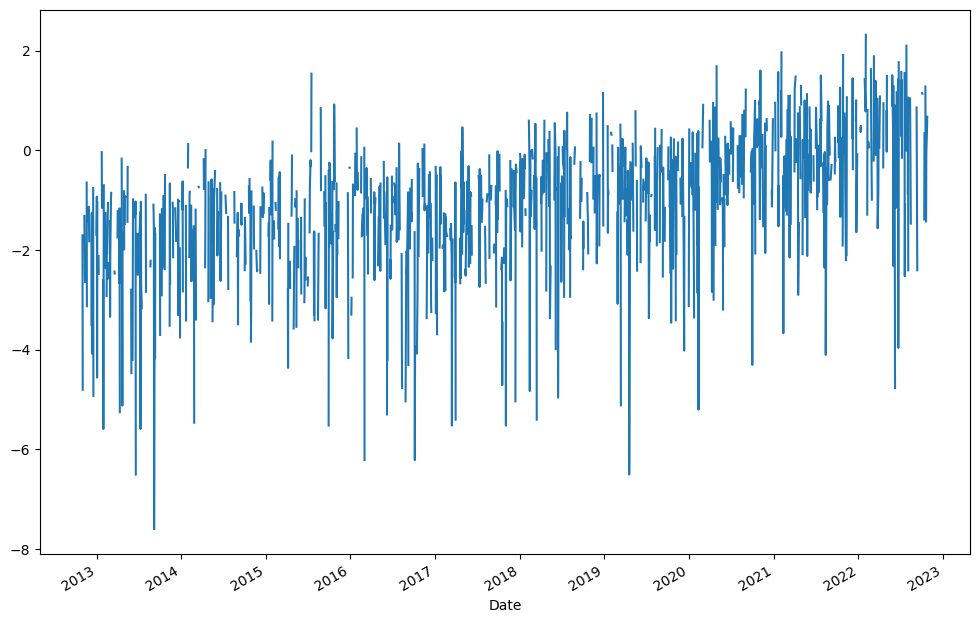

In [11]:
df_diff1_log = np.log(df_diff1)
df_diff1_log.plot(figsize=(12,8))
plt.show()

### acf, pacf를 통한 AR, MA 확인

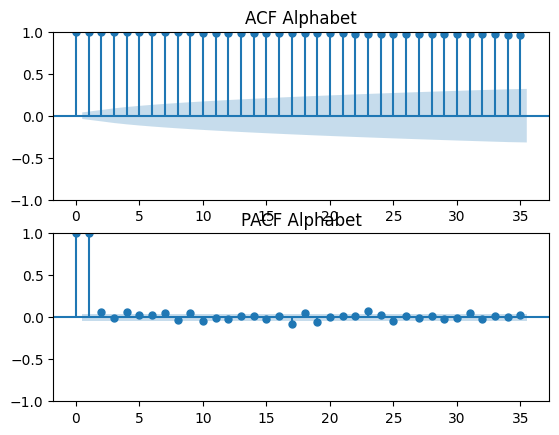

In [12]:

import statsmodels.graphics.tsaplots as sgt 
import matplotlib.pyplot as plt

## Close
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sgt.plot_acf(df['Adj Close'], ax=ax1)
ax1.set_title("ACF Alphabet")


sgt.plot_pacf(df['Adj Close'],method = ('ols'), ax=ax2)
ax2.set_title("PACF Alphabet")

plt.show()

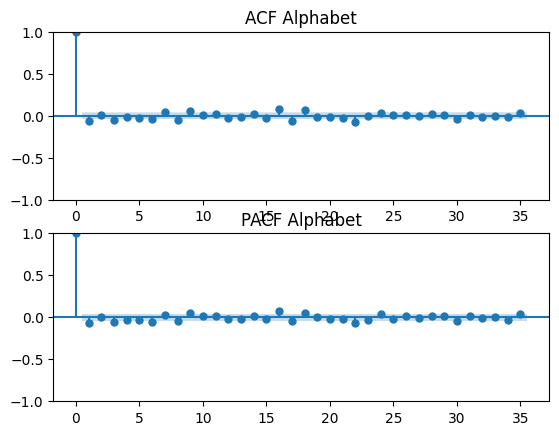

In [13]:
## Close
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sgt.plot_acf(df_diff1,  ax=ax1)
ax1.set_title("ACF Alphabet")


sgt.plot_pacf(df_diff1, method = ('ols'), ax=ax2)
ax2.set_title("PACF Alphabet")

plt.show()

### pmdarima 활용

In [16]:
import pmdarima as pm
from pmdarima.arima import ndiffs

n_diffs = ndiffs(df['Adj Close'])
n_diffs

1

In [17]:

model = pm.auto_arima(y=df['Adj Close'],
            d=1,
            start_p = 0, max_p=3,
            start_q = 0, max_q=3,
            seasonal=False,
            trace = True
            )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8231.556, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8221.824, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8221.860, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8231.192, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8223.799, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8223.097, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8225.820, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=8221.686, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=8223.648, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8222.890, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=8221.739, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=8224.664, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.850 seconds


In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2517
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -4108.843
Date:                Tue, 19 Mar 2024   AIC                           8221.686
Time:                        11:24:38   BIC                           8233.347
Sample:                             0   HQIC                          8225.918
                               - 2517                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0677      0.011     -6.070      0.000      -0.090      -0.046
sigma2         1.5346      0.018     87.291      0.000       1.500       1.569
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             10915.24
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              20.60   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

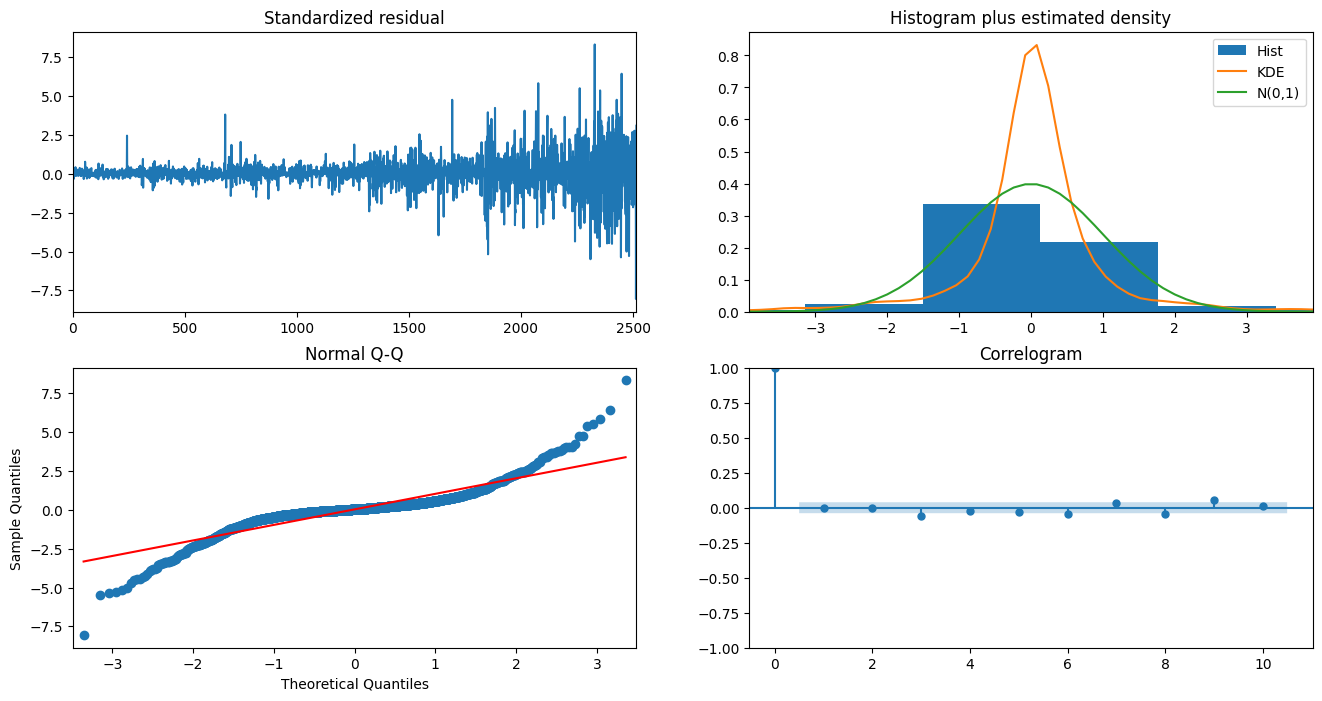

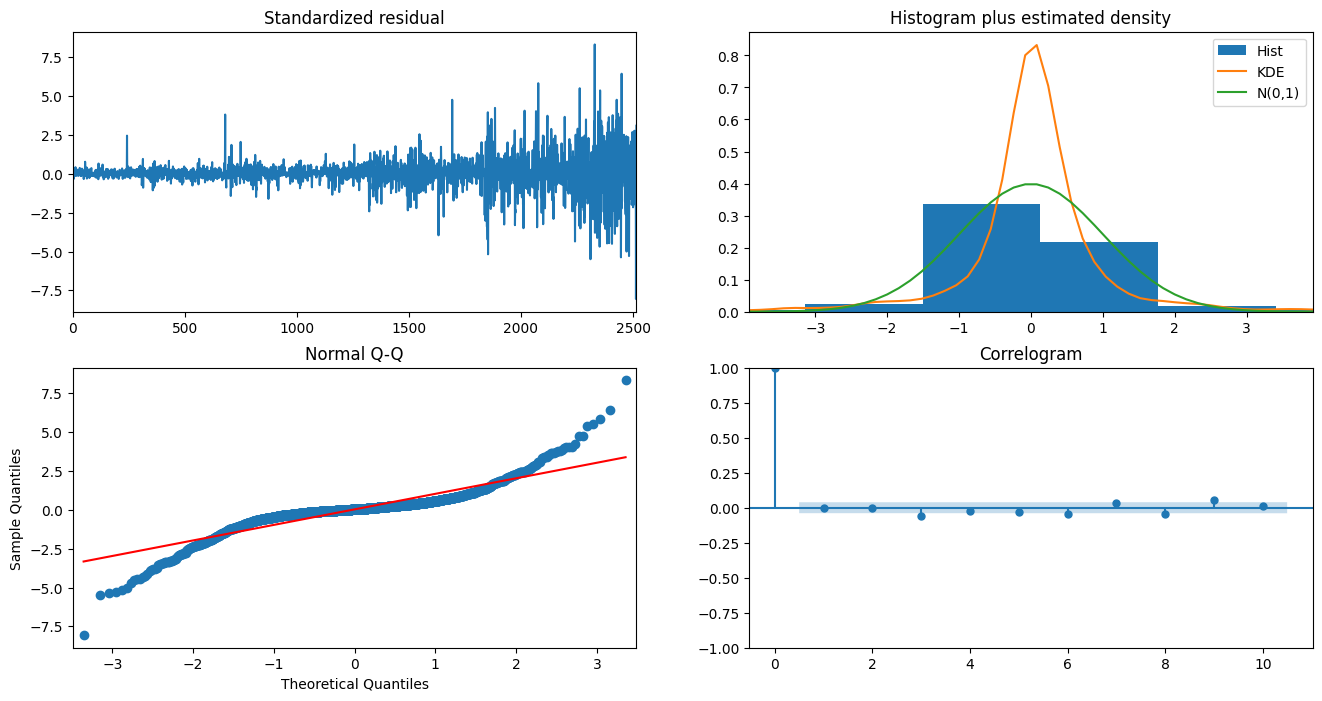

In [19]:
model.plot_diagnostics(figsize=(16 , 8))

### ARIMA 모델 학습과 테스트

In [21]:
# train_test_split을 안쓰는 이유 : 시계열데이터로 순서가 정해져있기 때문
train_data , test_data = df['Adj Close'][:int(len(df['Adj Close'])*0.9)] ,df['Adj Close'][int(len(df['Adj Close'])*0.9):]

In [22]:
# train_data 학습

model = pm.auto_arima(y=train_data,
            d=1,
            start_p = 0, max_p=3,
            start_q = 0, max_q=3,
            seasonal=False,
            trace = True
            )
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6127.619, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6119.112, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6119.471, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6134.024, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6120.306, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6118.765, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6120.764, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6120.763, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6120.804, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6120.503, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6126.014, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.316 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -3055.382
Date:                Tue, 19 Mar 2024   AIC                           6118.765
Time:                        13:12:46   BIC                           6141.664
Sample:                             0   HQIC                          6127.120
                               - 2265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0851      0.028      3.000      0.003       0.030       0.141
ar.L1         -0.4906      0.106     -4.650      0.000      -0.697      -0.284
ma.L1          0.4247      0.108      3.915      0.000       0.212       0.637
sigma2         0.8704      0.011     82.185      0.000       0.850       0.891
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9707.41
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              11.78   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
pred = model.predict(len(test_data))

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [24]:
pred_ = pd.Series(list(pred) , index=test_data.index)

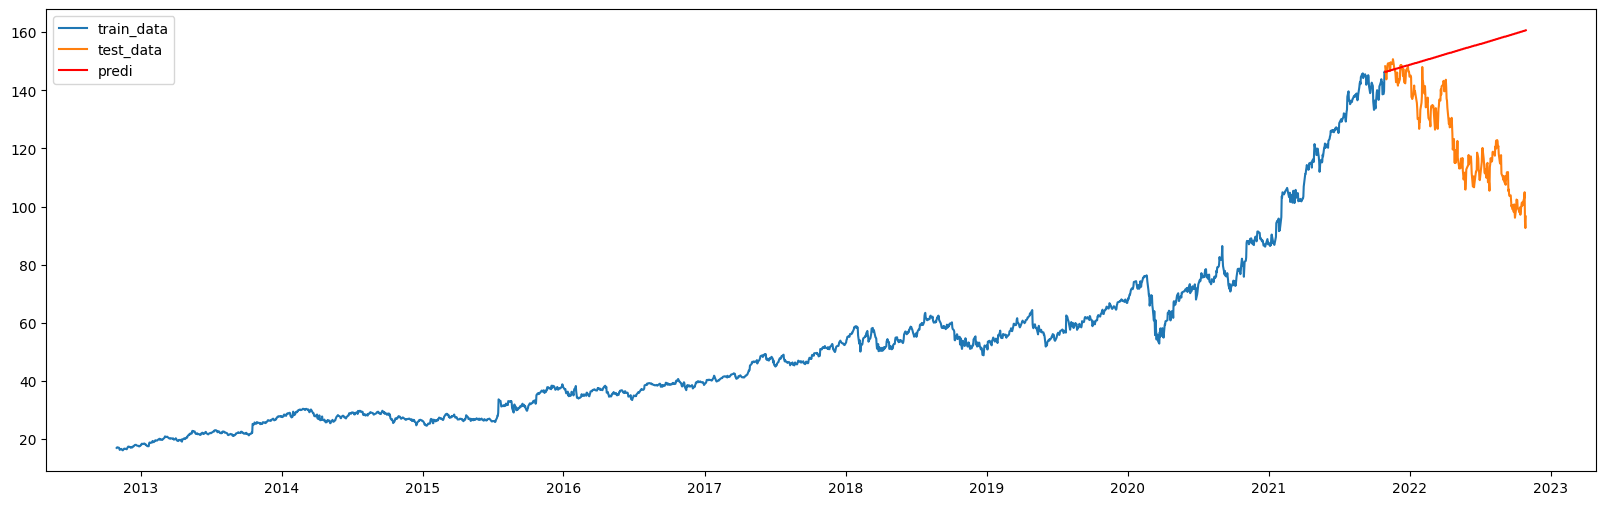

In [25]:
# train_data , test_data , pred plot
plt.figure(figsize=(20 ,6))
plt.plot(train_data , label='train_data')
plt.plot(test_data , label='test_data')
plt.plot(pred_ , c='red', label='predi')
plt.legend(loc='best')
plt.show()

In [26]:
#forecast 함수
def forecast_n_step(model , n=1):
    fc , conf_int = model.predict(n_periods=n , return_conf_int=True)
    return (fc.tolist()[0:n] , np.asarray(conf_int).tolist()[0:n] )

def forecast(length , model , index , data=None):
    y_pred = []
    pred_upper = []
    pred_lower = []

    if data is not None:
        for new_ob in data:
            fc , conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(new_ob)
    else:
        for i in range(length):
            fc , conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(fc[0])
    return pd.Series(y_pred , index=index) , pred_upper , pred_lower

In [27]:
# 예측
fc , upper , lower = forecast(len(test_data) , model , index=test_data.index , data=test_data)

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [28]:
upper_series = pd.Series(upper , index=test_data.index)
lower_series = pd.Series(lower , index=test_data.index)

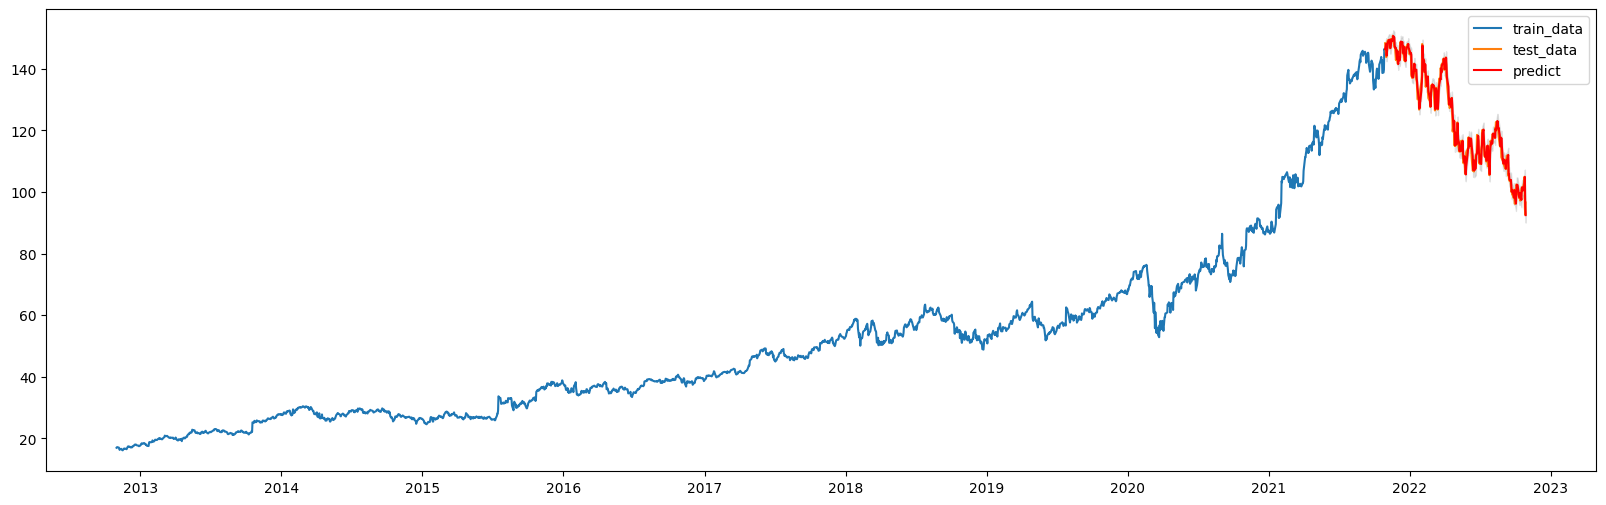

In [29]:
# train_data , test_data , pred plot
plt.figure(figsize=(20 ,6))
plt.plot(train_data , label='train_data')
plt.plot(test_data , label='test_data')
plt.plot(fc , c='red', label='predict')
plt.fill_between(lower_series.index ,lower_series , upper_series , color ='k' , alpha=0.10 )
plt.legend(loc='best')
plt.show()

### 평가

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: ' ,'{:.2f}%'.format(mape*100))

MSE:  4.440750562025714e+128
MAE:  4.208731937927018e+63
RMSE:  2.1073088435314162e+64
MAPE:  11708.26%
